## Bilayer unit domain. Sigma optimisation

In [13]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [14]:
# Define element size for the mesh refinement
h_i = [0,
       0,
       0.125/4,   # N=2
       0.125/8,   # N=3
       0.125/16,] # N=4
N=2 # mesh refinement reference (2,3,4)

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4

# Solver configuration
requested_eigenvalues_number = 30 # Number of eigenvalues to compute

In [25]:
gamma_piecewise = lambda x, w, sigma_0: 1 + (1j / w) * sigma_0
x_hat_piecewise = lambda x, w, sigma_0: np.where(x[0] >= Lx, x[0] + (1j / w) * sigma_0 * (x[0] - Lx), x[0])
sigma_x_piecewise_ufl=lambda x, sigma_0: conditional(x[0] >= Lx, sigma_0, 0.0)
sigma_x_piecewise_np=lambda x, sigma_0: np.where(x[0] >= Lx, sigma_0, 0.0)
sigma_x_function_cond= lambda x, sigma_0: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x_piecewise_np(x,sigma_0) ))

In [16]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

In [17]:
eig_number=1 #1,4
exact_eig=get_exact_eigenvalue(eig_number)  # Exact eigenvalue n (1,4)

Solver configuration and computing

In [18]:
# Polynomial degree for pressure and velocity
degree=[3,2]  
# Sweep of PML parameter sigma_0
sigma_sweep_piecewise=np.linspace(1., 70., 71)  

In [19]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-exact_eig*1j)  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()
    
    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [20]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof):
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real mayor que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        eig_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if eig_value.real > 1e-12:
            eigenvalues.append((eig_value, vrA.copy()))

    # Seleccionar el n-ésimo eigenvalor filtrado
    eig_value, vrA = eigenvalues[selected_index]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [eig_value, p_h, v_h]  # Return eigenfunction and eigenvalue

In [21]:
def get_exact_eigenpair(solver, selected_index, Q, V, x_hat, sigma_0, gamma_x, sigma_x_function_cond):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)
    x_value= lambda x: np.where(x[0] <= Lx, x[0], x_hat(x, w, sigma_0))
    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_value(x) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))
    # sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_0*(x[0]-Lx)**2))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x, sigma_0)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)* np.exp(1j * w / vel_media_2 * (np.where(x[0]>=Lx, x_hat(x,w, sigma_0),x[0]) - l_inner))*  gamma_x(x, w, sigma_0))
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

In [22]:
def get_closer_approx_eig(exact, solver, Q, V, dof, number_of_values=0):
    error = []
    for j in np.arange(number_of_values):
        error.append(np.abs(exact - get_approx_eigenpair(solver, j, Q, V, dof)[0]) / np.abs(exact))

    index_closest_eig = np.argmin(error)
    return get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[0], get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[1], get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[2], index_closest_eig

In [ ]:
# Initialize lists to store the approximated eigenpairs
approx_piecewise = [[0 for _ in range(1)] for _ in range(len(sigma_sweep_piecewise))]
approx_eigv_p = [[0 for _ in range(1)] for _ in range(len(sigma_sweep_piecewise))]
approx_eigv_v = [[0 for _ in range(1)] for _ in range(len(sigma_sweep_piecewise))]
# Create mesh depending on h
mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[N]), [0, Lx + pml_thickness])
for i,sigma_0 in zip(range(len(sigma_sweep_piecewise)),sigma_sweep_piecewise):
    # Define solver for piecewise PML
    sigma_x_fixed_sigma_0=lambda x: sigma_x_piecewise_ufl(x, sigma_0)
    # Get configured problem
    [solver_piecewise, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_fixed_sigma_0)
    [exact_eig_0, exact_eigv_0_p, exact_eigv_0_v]=get_exact_eigenpair(solver_piecewise, eig_number, Q_, V_,x_hat_piecewise, sigma_0, gamma_piecewise, sigma_x_function_cond)
    [approx_piecewise[i], approx_eigv_p[i],approx_eigv_v[i], index] = get_closer_approx_eig(exact_eig, solver_piecewise, Q_, V_, dof_, 15)
        
def remove_close_duplicates_with_indices(row, tol=1e-10):
    seen = set()
    unique = []
    indices = []
    for idx, z in enumerate(row):
        key = (round(z.real / tol) * tol, round(z.imag / tol) * tol)
        if key not in seen:
            seen.add(key)
            unique.append(z)
            indices.append(idx)
    return unique, indices

cleaned, indices = remove_close_duplicates_with_indices(approx_piecewise, tol=1e-10)
    
# Actualiza os autovalores
approx_piecewise = sorted(cleaned, key=lambda x: x.real)

In [28]:
[exact_eig, exact_eigv_p, exact_eigv_v]=get_exact_eigenpair(solver_piecewise, eig_number, Q_, V_,x_hat_piecewise, sigma_0, gamma_piecewise,sigma_x_function_cond)

In [29]:
x = np.linspace(0, 1.25, len(approx_eigv_p[0].x.array))
index_x_1 = np.where(np.isclose(x, 1.0))[0][0]
rel_error_eig = abs((approx_piecewise - exact_eig)) / np.abs(exact_eig)
rel_error_eigv_p = [
	np.linalg.norm(p.x.array[0:index_x_1] - exact_eigv_p.x.array[0:index_x_1]) / np.linalg.norm(exact_eigv_p.x.array[0:index_x_1])
	for p in approx_eigv_p
]
rel_error_total=rel_error_eigv_p+rel_error_eig


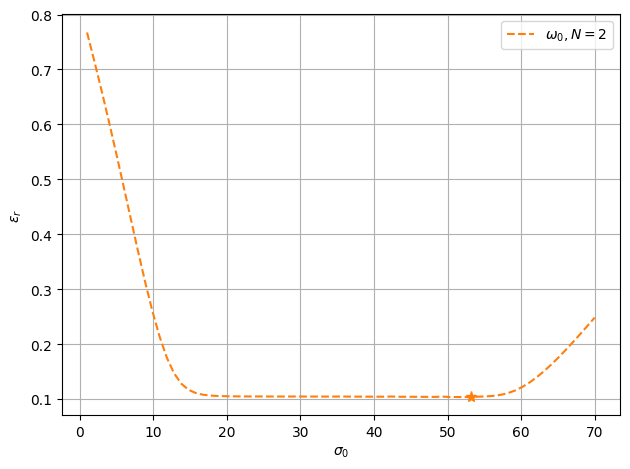

In [30]:
import matplotlib.pyplot as plt

# Definir colores manualmente (puedes elegir otros o usar un colormap como plt.cm.tab10)
colors = ['tab:green', 'tab:orange', 'tab:blue']  # uno por eig

plt.plot(sigma_sweep_piecewise, rel_error_total, color=colors[1], linestyle='--', label=f'$\omega_{eig_number-1}, N={N}$')
plt.plot(
    sigma_sweep_piecewise[np.argmin(rel_error_total)],
    rel_error_total[np.argmin(rel_error_total)],
    '*',
    color=colors[1],
    markersize=8,
)

plt.xlabel('$\sigma_0$')
plt.ylabel(r'$\epsilon_r$')
plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.io import savemat

# Crear un diccionario con los datos y metadatos
data_to_save = {
    f'sigma_sweep_piecewise_N{N}_eig{eig_number-1}': sigma_sweep_piecewise,
    f'rel_error_total_piecewise_N{N}_eig{eig_number-1}': rel_error_total,
    'N': N,
    'eig_number': eig_number-1,
    'description': f'Valores para N={N}, eig_number={eig_number-1}, piecewise'
}

# Guardar en un archivo .mat
savemat(f'data_piecewise_N{N}_eig{eig_number-1}.mat', data_to_save)